In [141]:
import numpy as np
import pandas as pd

%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

%pip install sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import randint

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Loading Data

### Parquets

In [142]:
taxi_trip_df = pd.read_parquet('yellow_tripdata_2024-12.parquet')

fhv_trip_df = pd.read_parquet('fhvhv_tripdata_2024-12.parquet')

taxi_zone_df = pd.read_csv('https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv')

In [143]:
taxi_trip_df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-12-01 00:12:27,2024-12-01 00:31:12,1.0,9.76,1.0,N,138,33,1,38.0,6.0,0.5,4.72,0.00,1.0,51.97,0.0,1.75
1,2,2024-11-30 23:56:04,2024-12-01 00:28:15,1.0,7.62,1.0,N,158,42,1,37.3,1.0,0.5,8.46,0.00,1.0,50.76,2.5,0.00
2,2,2024-12-01 00:50:35,2024-12-01 01:24:46,4.0,20.07,2.0,N,132,236,2,70.0,0.0,0.5,0.00,6.94,1.0,82.69,2.5,1.75
3,2,2024-12-01 00:18:16,2024-12-01 00:33:16,3.0,2.34,1.0,N,142,186,1,15.6,1.0,0.5,4.12,0.00,1.0,24.72,2.5,0.00
4,2,2024-12-01 00:56:13,2024-12-01 01:18:25,1.0,5.05,1.0,N,107,80,1,26.8,1.0,0.5,5.00,0.00,1.0,36.80,2.5,0.00
5,1,2024-12-01 00:21:17,2024-12-01 00:37:22,1.0,4.30,1.0,N,249,141,1,20.5,3.5,0.5,5.10,0.00,1.0,30.60,2.5,0.00
6,2,2024-12-01 00:04:53,2024-12-01 00:31:03,1.0,7.66,1.0,N,186,52,1,35.2,1.0,0.5,8.04,0.00,1.0,48.24,2.5,0.00
7,1,2024-12-01 00:15:28,2024-12-01 00:20:13,1.0,0.30,1.0,N,148,148,3,5.8,3.5,0.5,0.00,0.00,1.0,10.80,2.5,0.00
8,1,2024-12-01 00:38:54,2024-12-01 01:03:46,1.0,9.40,1.0,N,234,244,1,39.4,3.5,0.5,0.00,0.00,1.0,44.40,2.5,0.00
9,2,2024-12-01 00:00:21,2024-12-01 00:05:27,2.0,0.72,1.0,N,211,231,1,7.2,1.0,0.5,2.44,0.00,1.0,14.64,2.5,0.00


In [144]:
fhv_trip_df.head(10)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2024-12-01 00:26:25,2024-12-01 00:28:18,2024-12-01 00:30:18,2024-12-01 00:45:00,81,213,6.160,...,1.24,0.0,0.0,0.0,20.80,N,N,N,N,N
1,HV0003,B03404,B03404,2024-12-01 00:43:16,2024-12-01 00:46:46,2024-12-01 00:47:39,2024-12-01 00:55:03,213,213,1.810,...,0.95,0.0,0.0,0.0,10.62,N,N,N,N,N
2,HV0003,B03404,B03404,2024-12-01 00:02:09,2024-12-01 00:07:28,2024-12-01 00:09:29,2024-12-01 00:20:48,221,221,1.460,...,0.99,0.0,0.0,0.0,9.59,Y,N,N,N,N
3,HV0003,B03404,B03404,2024-12-01 00:20:28,2024-12-01 00:27:04,2024-12-01 00:29:05,2024-12-01 00:35:57,245,245,1.830,...,1.07,0.0,0.0,0.0,8.00,N,N,N,N,N
4,HV0003,B03404,B03404,2024-12-01 00:32:23,2024-12-01 00:35:52,2024-12-01 00:36:43,2024-12-01 01:05:17,245,109,9.290,...,3.86,0.0,0.0,0.0,30.79,N,N,N,N,N
5,HV0003,B03404,B03404,2024-12-01 00:07:55,2024-12-01 00:11:20,2024-12-01 00:11:29,2024-12-01 00:15:25,89,89,0.660,...,0.78,0.0,0.0,0.0,5.39,N,N,N,N,N
6,HV0003,B03404,B03404,2024-12-01 00:16:48,2024-12-01 00:21:08,2024-12-01 00:21:53,2024-12-01 00:25:22,89,89,0.470,...,0.79,0.0,0.0,5.0,5.39,N,N,N,N,N
7,HV0003,B03404,B03404,2024-12-01 00:46:41,2024-12-01 00:47:08,2024-12-01 00:47:47,2024-12-01 01:13:55,189,91,5.660,...,2.53,0.0,0.0,0.0,22.93,N,N,N,N,N
8,HV0005,B03406,None,2024-12-01 00:14:47,NaT,2024-12-01 00:20:11,2024-12-01 00:28:45,112,255,1.395,...,0.65,0.0,0.0,0.0,7.45,N,N,N,N,Y
9,HV0005,B03406,None,2024-12-01 00:26:21,NaT,2024-12-01 00:33:49,2024-12-01 00:39:07,255,80,0.931,...,0.57,0.0,0.0,2.0,5.47,N,N,N,N,Y


In [145]:
taxi_zone_df.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


### APIs

In [146]:
# Obtaining Url with SoQL Queries

permitted_events_historical_url = (
    "https://data.cityofnewyork.us/resource/bkfu-528j.json?" #json file
    "$limit=2000&" #limit
    "$where=start_date_time%20%3E%3D%20%272024-12-01T00:00:00%27" #start_date_time in Dec 2024
    "%20AND%20start_date_time%20%3C%20%272025-01-01T00:00:00%27"
    )

bus_ridership_url = (
    "https://data.ny.gov/resource/kv7t-n8in.json?" #json file
    "$limit=2000&" #limit
    "$where=transit_timestamp%20%3E%3D%20%272024-12-01T00:00:00%27" #transit_timestamp in Dec 2024
    "%20AND%20transit_timestamp%20%3C%20%272025-01-01T00:00:00%27"
)


# Read JSON

permitted_events_historical_df = pd.read_json(permitted_events_historical_url)

permitted_events_current_df = pd.read_json('https://data.cityofnewyork.us/resource/tvpp-9vvx.json?$limit=2000')

bus_ridership_df = pd.read_json(bus_ridership_url)

In [147]:
permitted_events_current_df.head(10)

,event_id,event_name,start_date_time,end_date_time,event_agency,event_type,event_borough,event_location,street_closure_type,community_board,police_precinct,event_street_side
0,821789,Baseball - 13 and Older (Little League),2025-03-24 15:30:00,2025-03-24 18:00:00,Parks Department,Sport - Youth,Manhattan,Randall's Island Park: Bronx Shore Fields-Base...,N/A,"11,","25,",NaN
1,825688,Soccer - Non Regulation,2025-03-19 18:00:00,2025-03-19 19:30:00,Parks Department,Sport - Youth,Manhattan,Randall's Island Park: Wards Meadow Fields-Soc...,N/A,"11,","25,",NaN
2,808693,Celebration,2025-05-24 11:00:00,2025-05-24 15:00:00,Parks Department,Special Event,Brooklyn,Marine Park: Picnic Area- E. 31 St,N/A,"18,","63,",NaN
3,817694,Homecrest Playground Family Day,2025-04-27 12:00:00,2025-04-27 15:00:00,Parks Department,Special Event,Brooklyn,Homecrest Playground: Playground,N/A,"15,","61,",NaN
4,810439,Miscellaneous,2025-05-15 09:00:00,2025-05-15 14:00:00,Parks Department,Special Event,Brooklyn,Dyker Beach Park: Dyker 14th Ave-Softball-01 ...,N/A,"10,","68,",NaN
5,820607,Soccer -Regulation,2025-03-15 14:00:00,2025-03-15 16:00:00,Parks Department,Sport - Adult,Queens,Forest Park: Soccer-01,N/A,"82,","102,",NaN
6,819895,Celebration,2025-09-30 12:00:00,2025-09-30 13:00:00,Parks Department,Special Event,Manhattan,"Central Park: Wagner Cove ,Central Park: Che...",N/A,"64,","22,",NaN
7,825678,Soccer - Non Regulation,2025-03-21 18:00:00,2025-03-21 19:30:00,Parks Department,Sport - Youth,Manhattan,Randall's Island Park: Wards Meadow Fields-Soc...,N/A,"11,","25,",NaN
8,819269,Celebration,2025-07-12 15:00:00,2025-07-12 17:00:00,Parks Department,Special Event,Manhattan,Central Park: Cop Cot,N/A,"64,","22,",NaN
9,823456,Soccer - Non Regulation,2025-06-21 12:00:00,2025-06-21 16:00:00,Parks Department,Sport - Youth,Manhattan,Riverside Park: 101st St-Soccer-04 C,N/A,"07,","24,",NaN


In [148]:
permitted_events_historical_df.head(10)

,event_id,event_name,start_date_time,end_date_time,event_agency,event_type,event_borough,event_location,street_closure_type,community_board,police_precinct,event_street_side
0,748554,MAYORS LAWN CLOSURE,2024-12-01,2024-12-01 23:59:00,Parks Department,Special Event,Manhattan,Carl Schurz Park: Oval (Mayor's) Lawn,N/A,"8,","19,",NaN
1,817671,"Mobile X RAY, testing unit",2024-12-01,2024-12-01 23:30:00,Street Activity Permit Office,Street Event,Manhattan,EAST 45 STREET between VANDERBILT AVENUE and...,Partial Sidewalk Closure,"5,","14, 18,",North
2,748554,MAYORS LAWN CLOSURE,2024-12-01,2024-12-01 23:59:00,Parks Department,Special Event,Manhattan,Carl Schurz Park: Oval (Mayor's) Lawn,N/A,"8,","19,",NaN
3,662787,Weekend and Holiday Lawn Closure East Meadow,2024-12-01,2024-12-01 23:59:00,Parks Department,Special Event,Manhattan,"Central Park: East Meadow ,Central Park: East ...",N/A,"64,","22,",NaN
4,812314,Marcus Garvey - Amphitheater closure - 2024 to...,2024-12-01,2024-12-01 23:59:00,Parks Department,Special Event,Manhattan,Marcus Garvey Park: Amphitheater,N/A,"11,","25,",NaN
5,817671,"Mobile X RAY, testing unit",2024-12-01,2024-12-01 23:30:00,Street Activity Permit Office,Street Event,Manhattan,EAST 45 STREET between VANDERBILT AVENUE and...,Partial Sidewalk Closure,"5,","14, 18,",North
6,748554,MAYORS LAWN CLOSURE,2024-12-01,2024-12-01 23:59:00,Parks Department,Special Event,Manhattan,Carl Schurz Park: Oval (Mayor's) Lawn,N/A,"8,","19,",NaN
7,662787,Weekend and Holiday Lawn Closure East Meadow,2024-12-01,2024-12-01 23:59:00,Parks Department,Special Event,Manhattan,"Central Park: East Meadow ,Central Park: East ...",N/A,"64,","22,",NaN
8,812314,Marcus Garvey - Amphitheater closure - 2024 to...,2024-12-01,2024-12-01 23:59:00,Parks Department,Special Event,Manhattan,Marcus Garvey Park: Amphitheater,N/A,"11,","25,",NaN
9,817671,"Mobile X RAY, testing unit",2024-12-01,2024-12-01 23:30:00,Street Activity Permit Office,Street Event,Manhattan,EAST 45 STREET between VANDERBILT AVENUE and...,Partial Sidewalk Closure,"5,","14, 18,",North


In [149]:
bus_ridership_df.sample(10)

,transit_timestamp,bus_route,payment_method,fare_class_category,ridership,transfers
462,2024-12-01T00:00:00.000,Q88,omny,OMNY - Other,0,0
1594,2024-12-01T00:00:00.000,M14A+,omny,OMNY - Seniors & Disability,0,0
474,2024-12-01T00:00:00.000,QM15,metrocard,Metrocard - Unlimited 30-Day,0,0
865,2024-12-01T00:00:00.000,Q47,metrocard,OMNY - Other,0,0
93,2024-12-01T00:00:00.000,B4,omny,OMNY - Other,0,0
1114,2024-12-01T00:00:00.000,BX19,omny,Metrocard - Students,0,0
1374,2024-12-01T00:00:00.000,SIM3,omny,Metrocard - Other,0,0
1055,2024-12-01T00:00:00.000,B4,metrocard,OMNY - Other,0,0
1772,2024-12-01T00:00:00.000,S81,metrocard,Metrocard - Fair Fare,0,0
884,2024-12-01T00:00:00.000,Q69,metrocard,Metrocard - Students,0,0


# Data Aggreration

### Filtering

Only include data from December 2024

In [150]:
taxi_trip_df = taxi_trip_df.loc[
    (taxi_trip_df['tpep_pickup_datetime'].dt.year == 2024) &
    (taxi_trip_df['tpep_pickup_datetime'].dt.month == 12)
    ]

taxi_trip_df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-12-01 00:12:27,2024-12-01 00:31:12,1.0,9.76,1.0,N,138,33,1,38.0,6.0,0.5,4.72,0.00,1.0,51.97,0.0,1.75
2,2,2024-12-01 00:50:35,2024-12-01 01:24:46,4.0,20.07,2.0,N,132,236,2,70.0,0.0,0.5,0.00,6.94,1.0,82.69,2.5,1.75
3,2,2024-12-01 00:18:16,2024-12-01 00:33:16,3.0,2.34,1.0,N,142,186,1,15.6,1.0,0.5,4.12,0.00,1.0,24.72,2.5,0.00
4,2,2024-12-01 00:56:13,2024-12-01 01:18:25,1.0,5.05,1.0,N,107,80,1,26.8,1.0,0.5,5.00,0.00,1.0,36.80,2.5,0.00
5,1,2024-12-01 00:21:17,2024-12-01 00:37:22,1.0,4.30,1.0,N,249,141,1,20.5,3.5,0.5,5.10,0.00,1.0,30.60,2.5,0.00
6,2,2024-12-01 00:04:53,2024-12-01 00:31:03,1.0,7.66,1.0,N,186,52,1,35.2,1.0,0.5,8.04,0.00,1.0,48.24,2.5,0.00
7,1,2024-12-01 00:15:28,2024-12-01 00:20:13,1.0,0.30,1.0,N,148,148,3,5.8,3.5,0.5,0.00,0.00,1.0,10.80,2.5,0.00
8,1,2024-12-01 00:38:54,2024-12-01 01:03:46,1.0,9.40,1.0,N,234,244,1,39.4,3.5,0.5,0.00,0.00,1.0,44.40,2.5,0.00
9,2,2024-12-01 00:00:21,2024-12-01 00:05:27,2.0,0.72,1.0,N,211,231,1,7.2,1.0,0.5,2.44,0.00,1.0,14.64,2.5,0.00
10,2,2024-12-01 00:07:13,2024-12-01 00:20:57,2.0,3.54,1.0,N,231,48,1,17.7,1.0,0.5,4.54,0.00,1.0,27.24,2.5,0.00


In [151]:
fhv_trip_df = fhv_trip_df.loc[
    (fhv_trip_df['request_datetime'].dt.year == 2024) &
    (fhv_trip_df['request_datetime'].dt.month == 12)
    ]

fhv_trip_df.head(10)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2024-12-01 00:26:25,2024-12-01 00:28:18,2024-12-01 00:30:18,2024-12-01 00:45:00,81,213,6.160,...,1.24,0.0,0.0,0.0,20.80,N,N,N,N,N
1,HV0003,B03404,B03404,2024-12-01 00:43:16,2024-12-01 00:46:46,2024-12-01 00:47:39,2024-12-01 00:55:03,213,213,1.810,...,0.95,0.0,0.0,0.0,10.62,N,N,N,N,N
2,HV0003,B03404,B03404,2024-12-01 00:02:09,2024-12-01 00:07:28,2024-12-01 00:09:29,2024-12-01 00:20:48,221,221,1.460,...,0.99,0.0,0.0,0.0,9.59,Y,N,N,N,N
3,HV0003,B03404,B03404,2024-12-01 00:20:28,2024-12-01 00:27:04,2024-12-01 00:29:05,2024-12-01 00:35:57,245,245,1.830,...,1.07,0.0,0.0,0.0,8.00,N,N,N,N,N
4,HV0003,B03404,B03404,2024-12-01 00:32:23,2024-12-01 00:35:52,2024-12-01 00:36:43,2024-12-01 01:05:17,245,109,9.290,...,3.86,0.0,0.0,0.0,30.79,N,N,N,N,N
5,HV0003,B03404,B03404,2024-12-01 00:07:55,2024-12-01 00:11:20,2024-12-01 00:11:29,2024-12-01 00:15:25,89,89,0.660,...,0.78,0.0,0.0,0.0,5.39,N,N,N,N,N
6,HV0003,B03404,B03404,2024-12-01 00:16:48,2024-12-01 00:21:08,2024-12-01 00:21:53,2024-12-01 00:25:22,89,89,0.470,...,0.79,0.0,0.0,5.0,5.39,N,N,N,N,N
7,HV0003,B03404,B03404,2024-12-01 00:46:41,2024-12-01 00:47:08,2024-12-01 00:47:47,2024-12-01 01:13:55,189,91,5.660,...,2.53,0.0,0.0,0.0,22.93,N,N,N,N,N
8,HV0005,B03406,None,2024-12-01 00:14:47,NaT,2024-12-01 00:20:11,2024-12-01 00:28:45,112,255,1.395,...,0.65,0.0,0.0,0.0,7.45,N,N,N,N,Y
9,HV0005,B03406,None,2024-12-01 00:26:21,NaT,2024-12-01 00:33:49,2024-12-01 00:39:07,255,80,0.931,...,0.57,0.0,0.0,2.0,5.47,N,N,N,N,Y


## Data Manipulation

### FHV DF

In [152]:
fhs_code = {'HV0002':'Juno', 'HV0003':'Uber', 'HV0004':'Via', 'HV0005':'Lyft'}

# Create a new column for For-Hire Services
fhv_trip_df['service_provider'] = fhv_trip_df['hvfhs_license_num'].replace(fhs_code)

# Remove unnecessary columns
fhv_trip_df.drop(columns=['hvfhs_license_num',
                          'dispatching_base_num','originating_base_num',
                          'shared_request_flag','shared_match_flag','access_a_ride_flag',
                          'wav_request_flag','wav_match_flag','DOLocationID','on_scene_datetime','dropoff_datetime','trip_miles','trip_time',
                          'base_passenger_fare','tolls','bcf','sales_tax','tips','driver_pay'
                          ], 
                          inplace=True)

fhv_trip_df.sample(10)

,request_datetime,pickup_datetime,PULocationID,congestion_surcharge,airport_fee,service_provider
20681002,2024-12-31 16:33:03,2024-12-31 16:36:09,63,0.00,0.0,Uber
11123246,2024-12-16 10:11:14,2024-12-16 10:19:49,68,2.75,0.0,Lyft
17059095,2024-12-24 21:26:27,2024-12-24 21:31:44,238,2.75,0.0,Uber
9283642,2024-12-13 23:44:11,2024-12-13 23:46:44,87,2.75,0.0,Uber
19541758,2024-12-29 12:43:47,2024-12-29 12:44:33,132,0.00,2.5,Lyft
11672992,2024-12-17 08:20:19,2024-12-17 08:23:53,121,0.00,0.0,Uber
12347877,2024-12-18 09:23:16,2024-12-18 09:27:59,91,0.00,0.0,Uber
13414153,2024-12-19 19:02:09,2024-12-19 19:05:53,137,2.75,0.0,Uber
2648060,2024-12-05 07:08:56,2024-12-05 07:18:07,258,0.00,0.0,Lyft
12338608,2024-12-18 08:52:15,2024-12-18 08:59:51,33,2.75,0.0,Uber


In [153]:
fhv_trip_df['waiting_time'] = fhv_trip_df['pickup_datetime'].dt.minute - fhv_trip_df['request_datetime'].dt.minute

fhv_trip_df.head(10)

,request_datetime,pickup_datetime,PULocationID,congestion_surcharge,airport_fee,service_provider,waiting_time
0,2024-12-01 00:26:25,2024-12-01 00:30:18,81,0.0,0.0,Uber,4
1,2024-12-01 00:43:16,2024-12-01 00:47:39,213,0.0,0.0,Uber,4
2,2024-12-01 00:02:09,2024-12-01 00:09:29,221,0.0,0.0,Uber,7
3,2024-12-01 00:20:28,2024-12-01 00:29:05,245,0.0,0.0,Uber,9
4,2024-12-01 00:32:23,2024-12-01 00:36:43,245,0.0,0.0,Uber,4
5,2024-12-01 00:07:55,2024-12-01 00:11:29,89,0.0,0.0,Uber,4
6,2024-12-01 00:16:48,2024-12-01 00:21:53,89,0.0,0.0,Uber,5
7,2024-12-01 00:46:41,2024-12-01 00:47:47,189,0.0,0.0,Uber,1
8,2024-12-01 00:14:47,2024-12-01 00:20:11,112,0.0,0.0,Lyft,6
9,2024-12-01 00:26:21,2024-12-01 00:33:49,255,0.0,0.0,Lyft,7


In [154]:
print(fhv_trip_df['waiting_time'].isnull().sum() / len(fhv_trip_df)* 100)

0.0


In [155]:
fhv_trip_df.drop(columns=['request_datetime'],inplace=True)

### Trips DF

In [156]:
taxi_trip_df['service_provider'] = 'Taxi' #Purpose: To fill in the 'service_provider' before joining the FHV DataFrame
taxi_trip_df['waiting_time'] = 0.0 #Purpose: To fill in missing values before joining with the FHV DataFrame

taxi_trip_df.rename(columns={'tpep_pickup_datetime':'pickup_datetime'}, inplace=True)

taxi_trip_df.drop(columns=['VendorID','passenger_count','store_and_fwd_flag',
                           'Airport_fee','improvement_surcharge','tolls_amount','tip_amount','mta_tax',
                           'payment_type','DOLocationID','RatecodeID','trip_distance','tpep_dropoff_datetime',
                           'fare_amount','total_amount','extra'
                           ], inplace=True)

taxi_trip_df.head(10)                        

,pickup_datetime,PULocationID,congestion_surcharge,service_provider,waiting_time
0,2024-12-01 00:12:27,138,0.0,Taxi,0.0
2,2024-12-01 00:50:35,132,2.5,Taxi,0.0
3,2024-12-01 00:18:16,142,2.5,Taxi,0.0
4,2024-12-01 00:56:13,107,2.5,Taxi,0.0
5,2024-12-01 00:21:17,249,2.5,Taxi,0.0
6,2024-12-01 00:04:53,186,2.5,Taxi,0.0
7,2024-12-01 00:15:28,148,2.5,Taxi,0.0
8,2024-12-01 00:38:54,234,2.5,Taxi,0.0
9,2024-12-01 00:00:21,211,2.5,Taxi,0.0
10,2024-12-01 00:07:13,231,2.5,Taxi,0.0


## Bus DF

In [157]:
bus_ridership_df.dtypes

transit_timestamp      object
bus_route              object
payment_method         object
fare_class_category    object
ridership               int64
transfers               int64
dtype: object

In [158]:
bus_ridership_df['transit_timestamp'] = pd.to_datetime(bus_ridership_df['transit_timestamp'])

bus_ridership_df.dtypes

transit_timestamp      datetime64[ns]
bus_route                      object
payment_method                 object
fare_class_category            object
ridership                       int64
transfers                       int64
dtype: object

In [159]:
bus_ridership_df['transit_timestamp'] = bus_ridership_df['transit_timestamp'].astype('datetime64[us]')

bus_ridership_df.dtypes

transit_timestamp      datetime64[us]
bus_route                      object
payment_method                 object
fare_class_category            object
ridership                       int64
transfers                       int64
dtype: object

In [160]:
bus_ridership_df.rename(columns={
    'transit_timestamp':'pickup_datetime',
    'ridership':'number_of_bus_riders'
    },inplace=True)

# Drop unnecessary columns
bus_ridership_df.drop(columns=['payment_method','bus_route','fare_class_category','transfers'],inplace=True)

In [161]:
bus_ridership_df.head(10)

,pickup_datetime,number_of_bus_riders
0,2024-12-01,0
1,2024-12-01,0
2,2024-12-01,0
3,2024-12-01,0
4,2024-12-01,0
5,2024-12-01,0
6,2024-12-01,0
7,2024-12-01,2
8,2024-12-01,0
9,2024-12-01,0


In [162]:
len(bus_ridership_df)

2000

## Joining Taxi & For-Hire DF

In [163]:
trips_df = taxi_trip_df.merge(fhv_trip_df, how='outer', on=[
    'pickup_datetime','service_provider','PULocationID','congestion_surcharge', 'waiting_time'
    ])

trips_df.head(10)

,pickup_datetime,PULocationID,congestion_surcharge,service_provider,waiting_time,airport_fee
0,2024-12-01 00:00:00,144,2.5,Taxi,0.0,NaN
1,2024-12-01 00:00:01,177,0.0,Lyft,-11.0,0.0
2,2024-12-01 00:00:02,48,2.5,Taxi,0.0,NaN
3,2024-12-01 00:00:04,114,2.5,Taxi,0.0,NaN
4,2024-12-01 00:00:04,170,2.5,Taxi,0.0,NaN
5,2024-12-01 00:00:06,132,2.5,Taxi,0.0,NaN
6,2024-12-01 00:00:06,249,2.5,Taxi,0.0,NaN
7,2024-12-01 00:00:07,163,2.5,Taxi,0.0,NaN
8,2024-12-01 00:00:09,114,2.5,Taxi,0.0,NaN
9,2024-12-01 00:00:09,186,2.5,Taxi,0.0,NaN


In [164]:
trips_df.sample(10)

,pickup_datetime,PULocationID,congestion_surcharge,service_provider,waiting_time,airport_fee
22818604,2024-12-29 04:42:19,188,0.00,Uber,6.0,0.0
11458107,2024-12-14 13:09:17,206,0.00,Uber,7.0,0.0
14115455,2024-12-17 15:50:33,142,2.75,Uber,5.0,0.0
10083519,2024-12-13 01:36:23,249,2.75,Uber,17.0,0.0
20282113,2024-12-25 01:46:29,198,0.00,Lyft,6.0,0.0
17163482,2024-12-21 02:06:35,141,2.75,Uber,3.0,0.0
23395692,2024-12-30 04:12:35,129,0.00,Lyft,6.0,0.0
14528214,2024-12-18 05:53:54,169,0.75,Uber,4.0,0.0
20211399,2024-12-24 23:16:06,248,0.00,Uber,7.0,0.0
21298039,2024-12-26 21:33:17,132,0.00,Taxi,0.0,NaN


In [165]:
len(trips_df)

24733952

# Data Exploration

### Trips 

<Axes: xlabel='service_provider', ylabel='Count'>

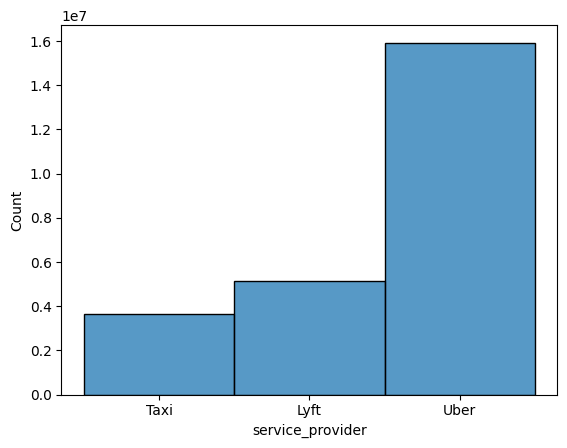

In [166]:
sns.histplot(x=trips_df['service_provider'])

<Axes: xlabel='pickup_datetime', ylabel='Count'>

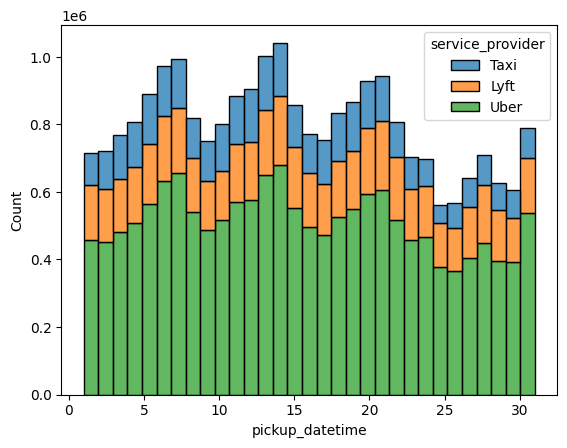

In [167]:
sns.histplot(data=trips_df, x=trips_df['pickup_datetime'].dt.day, bins=31, hue='service_provider', multiple='stack')

<Axes: xlabel='pickup_datetime', ylabel='Count'>

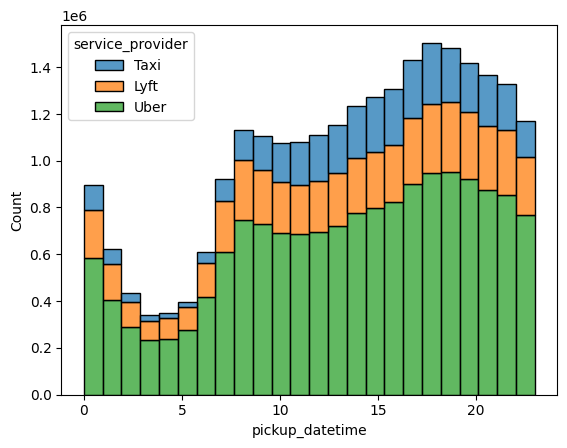

In [168]:
sns.histplot(data=trips_df, x=trips_df['pickup_datetime'].dt.hour, bins=24, hue='service_provider', multiple='stack')

<Axes: xlabel='PULocationID', ylabel='Count'>

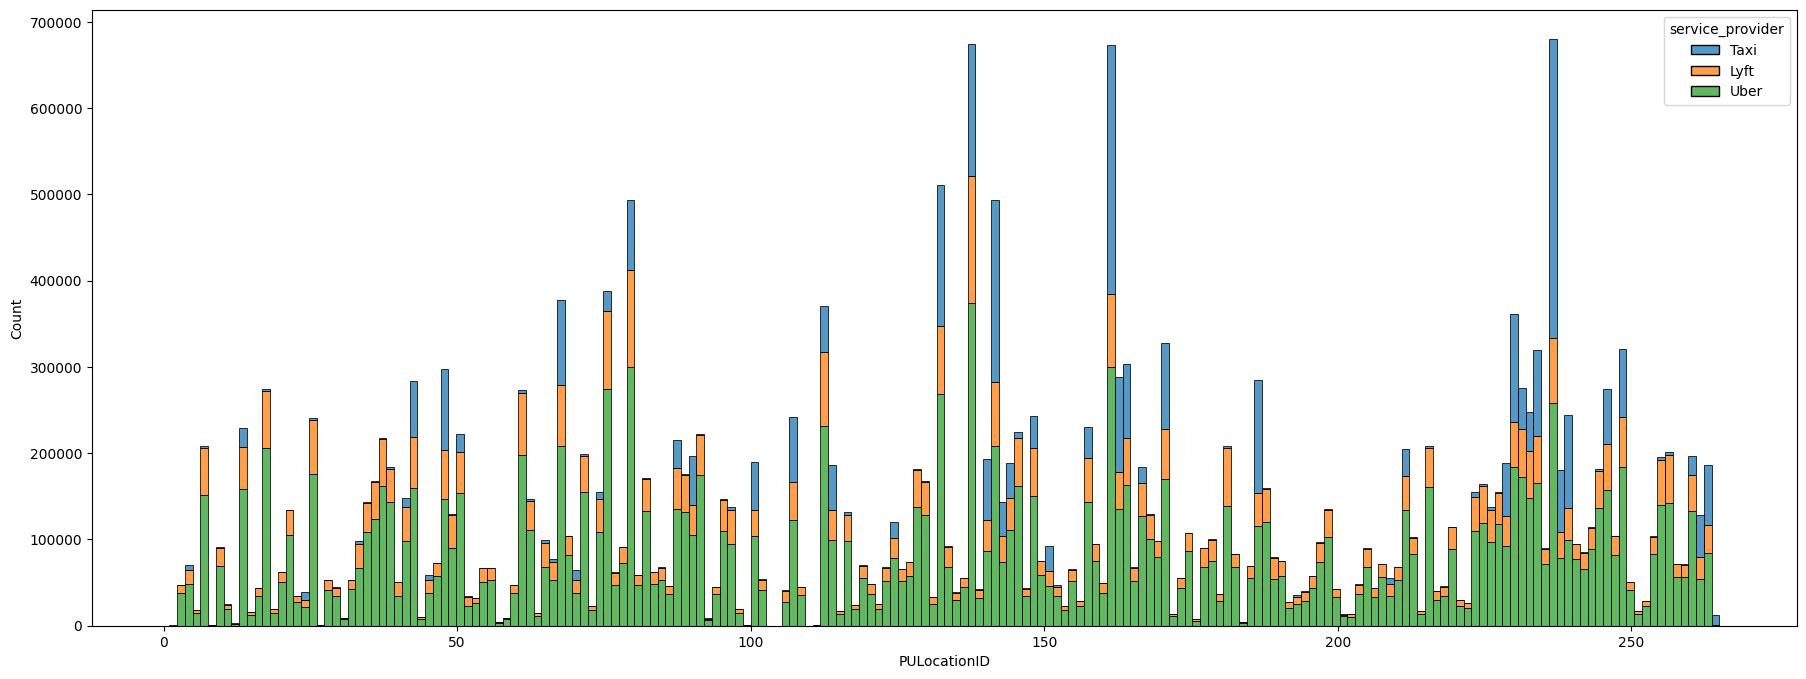

In [169]:
plt.figure(figsize=(22,8))
sns.histplot(data=trips_df, x='PULocationID', hue='service_provider', bins=200, multiple='stack')

### Permitted Events

In [170]:
sns.histplot(data=permitted_events_df, x=permitted_events_df['event_borough'])

NameError: name 'permitted_events_df' is not defined

Text(0.5, 1.0, 'Number of Events in a Month (per Borough)')

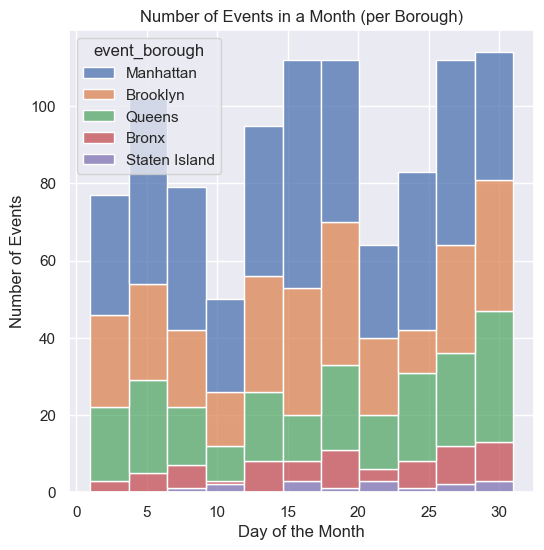

In [ ]:
plt.figure(figsize=(6,6))
sns.histplot(data=permitted_events_df, x=permitted_events_df['start_date_time'].dt.day, hue='event_borough', multiple='stack')

plt.xlabel('Day of the Month')
plt.ylabel('Number of Events')
plt.title('Number of Events in a Month (per Borough)')

Text(0.5, 1.0, 'Number of Events in a Week (per Borough)')

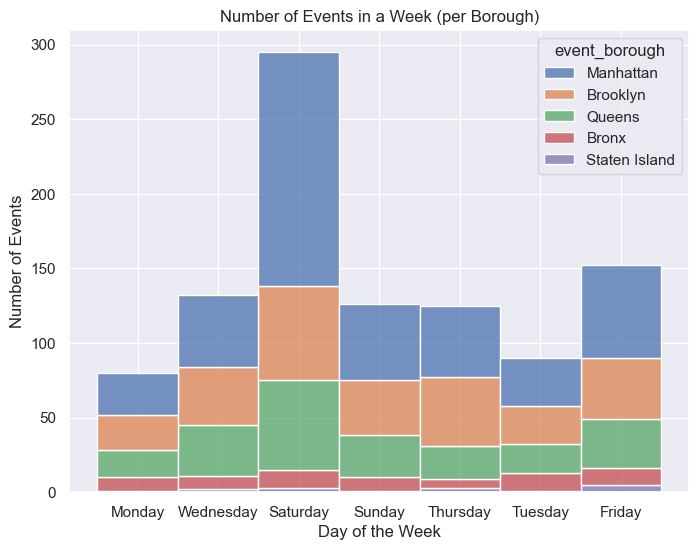

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=permitted_events_df, x=permitted_events_df['start_date_time'].dt.day_name(), hue='event_borough', multiple='stack')

plt.xlabel('Day of the Week')
plt.ylabel('Number of Events')
plt.title('Number of Events in a Week (per Borough)')

Text(0.5, 1.0, 'Number of Events in a Day (per Borough)')

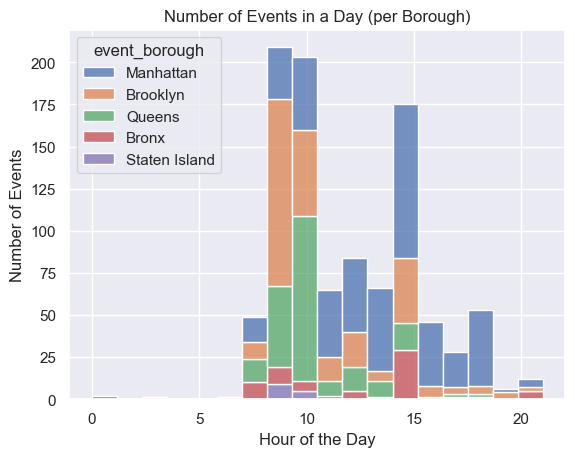

In [ ]:
sns.histplot(data=permitted_events_df, x=permitted_events_df['start_date_time'].dt.hour, hue='event_borough', multiple='stack')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')
plt.title('Number of Events in a Day (per Borough)')

# Creating Demand DataFrame

In [ ]:
demand_df = trips_df.copy()

demand_df['date'] = demand_df['pickup_datetime'].dt.date
demand_df['hour'] = demand_df['pickup_datetime'].dt.hour

demand_df.drop(columns=['pickup_datetime'],inplace=True)

demand_df= demand_df.groupby(['date','hour','service_provider','PULocationID']).size().reset_index(name='number_of_rides')

,date,hour,service_provider,PULocationID,number_of_rides
0,2024-12-01,0,Lyft,3,9
1,2024-12-01,0,Lyft,4,40
2,2024-12-01,0,Lyft,5,1
3,2024-12-01,0,Lyft,6,2
4,2024-12-01,0,Lyft,7,103
5,2024-12-01,0,Lyft,9,6
6,2024-12-01,0,Lyft,10,12
7,2024-12-01,0,Lyft,11,4
8,2024-12-01,0,Lyft,13,8
9,2024-12-01,0,Lyft,14,41


In [51]:
demand_df.sample(20)

,date,hour,service_provider,PULocationID,number_of_rides
63488,2024-12-05,8,Taxi,43,93
112705,2024-12-08,15,Uber,109,9
35672,2024-12-03,10,Uber,94,57
171174,2024-12-12,15,Taxi,195,1
11849,2024-12-01,19,Lyft,219,8
353239,2024-12-24,20,Lyft,4,27
425703,2024-12-29,18,Lyft,179,29
60472,2024-12-05,3,Taxi,188,1
176840,2024-12-13,0,Taxi,239,46
381504,2024-12-26,17,Uber,115,16


<Axes: xlabel='PULocationID', ylabel='hour'>

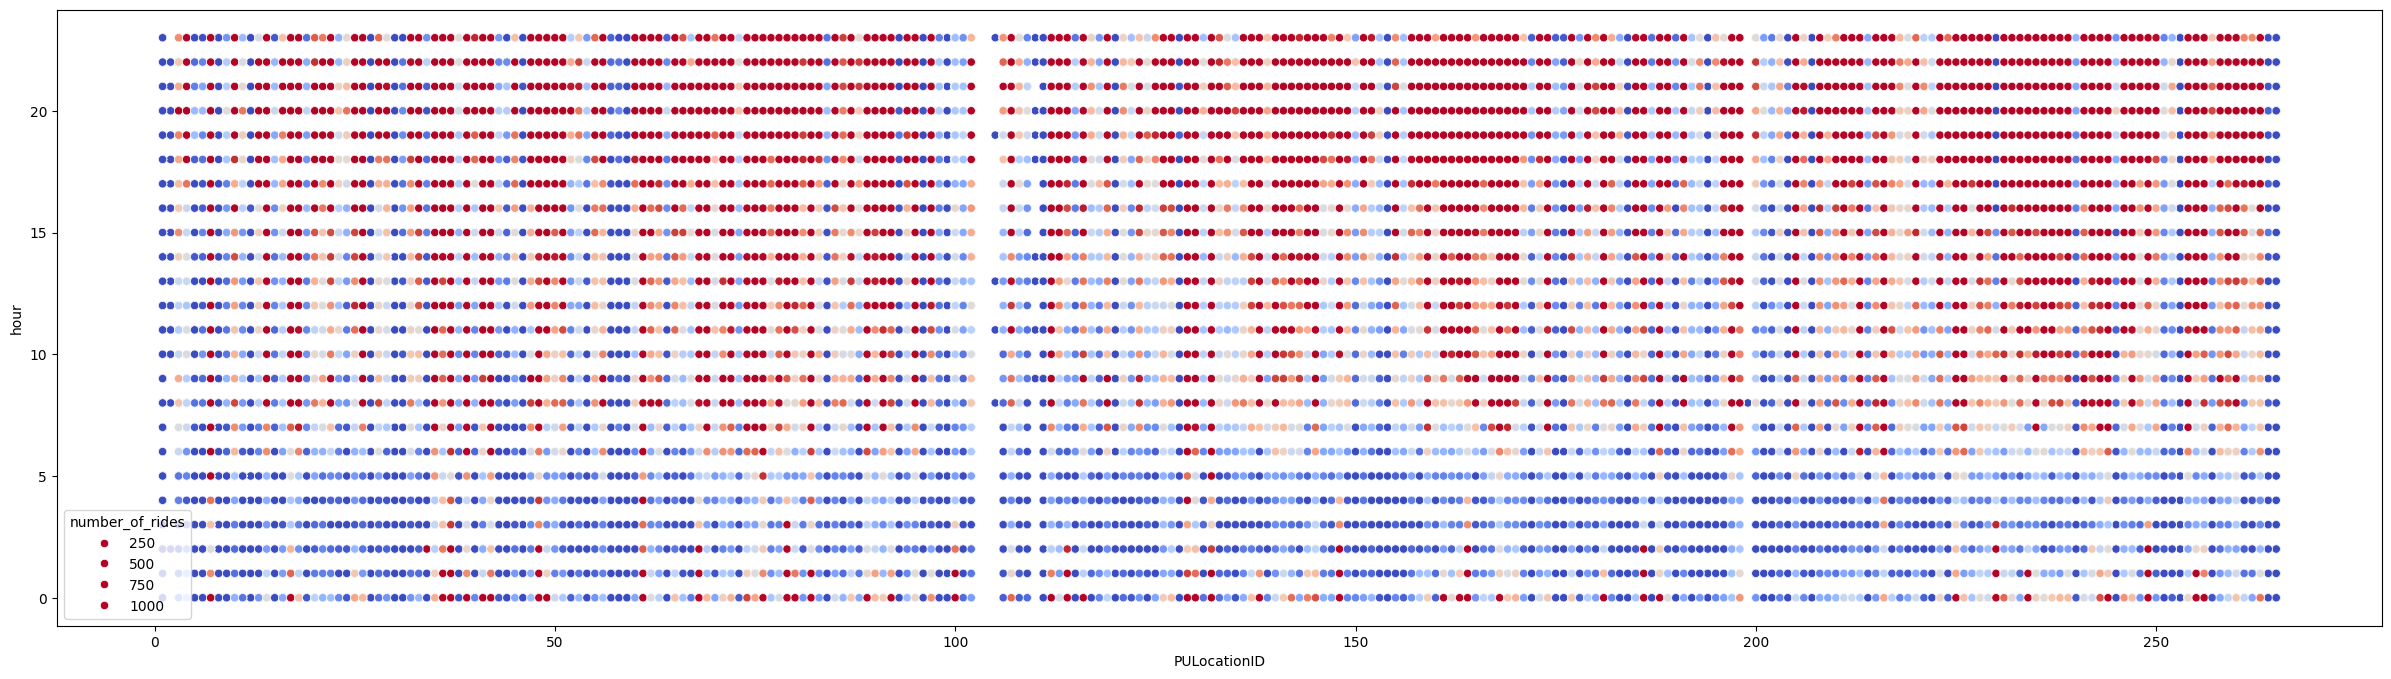

In [ ]:
plt.figure(figsize=(30,8))
sns.scatterplot(x=demand_df['PULocationID'], y=demand_df['hour'], hue=demand_df['number_of_rides'], palette='coolwarm', hue_norm=(10, 100))